In [2]:
import tensorflow as tf
print("imported")

imported


In [3]:
import numpy as np

In [4]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check GPU information
print("GPU devices:", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
TensorFlow version: 2.10.1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [6]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [7]:
def multi_unet_model(n_classes=11, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model

In [10]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Cropping2D
from keras.models import Model

def multi_unet_model(n_classes=11, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    # Crop c4 to have the same shape as u6
    c4_crop = Cropping2D(cropping=((0, 0), (0, 0)))(c4)
    u6 = concatenate([u6, c4_crop])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    # Crop c3 to have the same shape as u7
    c3_crop = Cropping2D(cropping=((0, 0), (0, 0)))(c3)
    u7 = concatenate([u7, c3_crop])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    # Crop c2 to have the same shape as u8
    c2_crop = Cropping2D(cropping=((0, 0), (0, 0)))(c2)
    u8 = concatenate([u8, c2_crop])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    # Crop c1 to have the same shape as u9
    c1_crop = Cropping2D(cropping=((0, 0), (0, 0)))(c1)
    u9 = concatenate([u9, c1_crop], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Cropping2D
from tensorflow.keras.models import Model

def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contracting Path
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    c4_crop = Cropping2D(cropping=((1, 1), (1, 1)))(c4)
    u6 = concatenate([u6, c4_crop])
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    c3_crop = Cropping2D(cropping=((1, 1), (1, 1)))(c3)
    u7 = concatenate([u7, c3_crop])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    c2_crop = Cropping2D(cropping=((1, 1), (1, 1)))(c2)
    u8 = concatenate([u8, c2_crop])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
       
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    c1_crop = Cropping2D(cropping=((1, 1), (1, 1)))(c1)
    u9 = concatenate([u9, c1_crop], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model

   

In [8]:
SIZE_X = 256
SIZE_Y = 256
n_classes=11 #Number of classes for segmentation
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("D:/cources/Internship/2023/ASDC AI & Data analysis internship/dataset/semantic segmentation/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 0) 
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

In [9]:
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
train_images.shape

(100, 256, 256)

In [10]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("D:/cources/Internship/2023/ASDC AI & Data analysis internship/dataset/semantic segmentation/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpg___fuse.png")): #.jpg___save.png
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)


In [11]:
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
train_masks.shape

(100, 256, 256)

In [12]:
np.unique(train_masks)

array([  0,  66,  79,  90,  96, 129, 169, 170, 191, 213, 214], dtype=uint8)

In [13]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)


In [14]:
train_masks_reshaped_encoded

array([3, 3, 3, ..., 5, 5, 5], dtype=int64)

In [15]:
np.unique(train_masks_encoded_original_shape)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [16]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_images.shape

(100, 256, 256, 1)

In [17]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
train_masks_input.shape

(100, 256, 256, 1)

In [18]:
from sklearn.model_selection import train_test_split
#Further split training data t a smaller subset for quick testing of models
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.2, random_state = 0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(80, 256, 256, 1) (20, 256, 256, 1) (80, 256, 256, 1) (20, 256, 256, 1)


In [19]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
y_train_cat.shape

(80, 256, 256, 11)

In [20]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
y_test_cat.shape

(20, 256, 256, 11)

In [21]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [22]:
 X_train.shape

(80, 256, 256, 1)

In [25]:
 model= multi_unet_model(n_classes=n_classes,
                        IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH,
                        IMG_CHANNELS=IMG_CHANNELS)

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [27]:
model.load_weights('test.hdf5')
history = model.fit(X_train, y_train_cat, 
                    batch_size=16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/50
5/5 [==============================] - 21s 2s/step - loss: 0.9968 - accuracy: 0.8192 - val_loss: 0.5854 - val_accuracy: 0.8486
Epoch 2/50
5/5 [==============================] - 5s 945ms/step - loss: 0.5956 - accuracy: 0.8277 - val_loss: 0.5890 - val_accuracy: 0.8463
Epoch 3/50
5/5 [==============================] - 5s 955ms/step - loss: 0.5183 - accuracy: 0.8419 - val_loss: 0.4286 - val_accuracy: 0.8774
Epoch 4/50
5/5 [==============================] - 5s 947ms/step - loss: 0.4276 - accuracy: 0.8669 - val_loss: 0.3603 - val_accuracy: 0.8905
Epoch 5/50
5/5 [==============================] - 5s 951ms/step - loss: 0.3780 - accuracy: 0.8791 - val_loss: 0.3435 - val_accuracy: 0.8966
Epoch 6/50
5/5 [==============================] - 5s 948ms/step - loss: 0.3439 - accuracy: 0.8891 - val_loss: 0.3227 - val_accuracy: 0.9031
Epoch 7/50
5/5 [==============================] - 5s 960ms/step - loss: 0.3186 - accuracy: 0.8962 - val_loss: 0.3099 - val_accuracy: 0.9059
Epoch 8/50
5/5 [======

In [40]:
# model.save('test.hdf5')


In [29]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

1/1 [==============================] - 8s 8s/step - loss: 0.2490 - accuracy: 0.9323
Accuracy is =  93.22738647460938 %


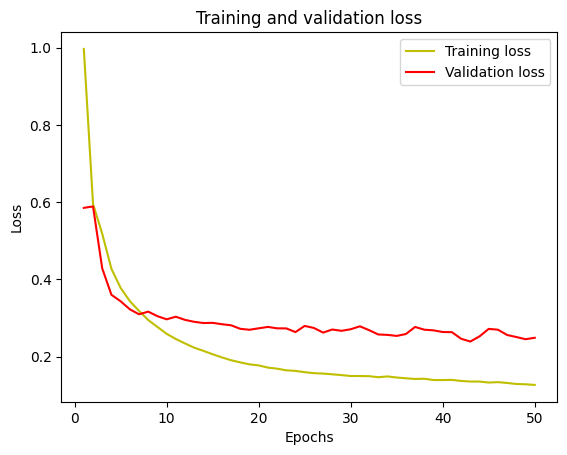

In [30]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

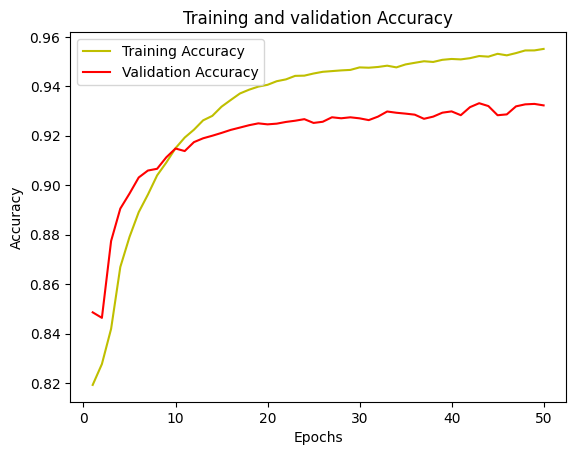

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 0s 264ms/step


In [33]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 11
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.50178456


CLASS DISTRIBUTION.
Classes Instances Count Concentration Ratio
Team B 210 23%
Team A 192 21%
Advertisement 96 10.5%
Audience 94 10.3%
Ground 86 9.4%
Goal Bar 64 7%
Ball 64 7%
Goalkeeper B 47 5.1%
Goalkeeper A 38 4.2%
Referee 24 2.6%
Coaches & Officials 0 0

In [34]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

# Assuming values is your IoU matrix with shape (n_classes, n_classes)
# You can extract n_classes dynamically
n_classes = values.shape[0]

# Initialize an array to store class IoU values
class_iou = np.zeros(n_classes)

# Calculate IoU for each class
for i in range(n_classes):
    # Numerator: True Positive (TP) for the current class
    tp = values[i, i]
    
    # Denominator: TP + False Positive (FP) + False Negative (FN) for the current class
    denominator = np.sum(values[i, :]) + np.sum(values[:, i]) - tp
    
    # Avoid division by zero
    if denominator != 0:
        class_iou[i] = tp / denominator
    else:
        class_iou[i] = 0.0

# Print IoU for each class
for i in range(n_classes):
    print(f"IoU for class {i+1} is: {class_iou[i]}")


IoU for class 1 is: 0.0
IoU for class 2 is: 0.8479796051979065
IoU for class 3 is: 0.666224479675293
IoU for class 4 is: 0.9214982986450195
IoU for class 5 is: 0.0
IoU for class 6 is: 0.9472317695617676
IoU for class 7 is: 0.1772654950618744
IoU for class 8 is: 0.6424543261528015
IoU for class 9 is: 0.25912344455718994
IoU for class 10 is: 0.7097888588905334
IoU for class 11 is: 0.3480638861656189


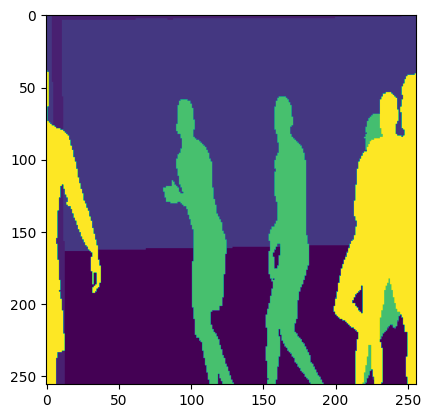

In [37]:
plt.imshow(train_images[0, :,:,0])
plt.imshow(train_masks[0])

In [35]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


1/1 [==============================] - 2s 2s/step


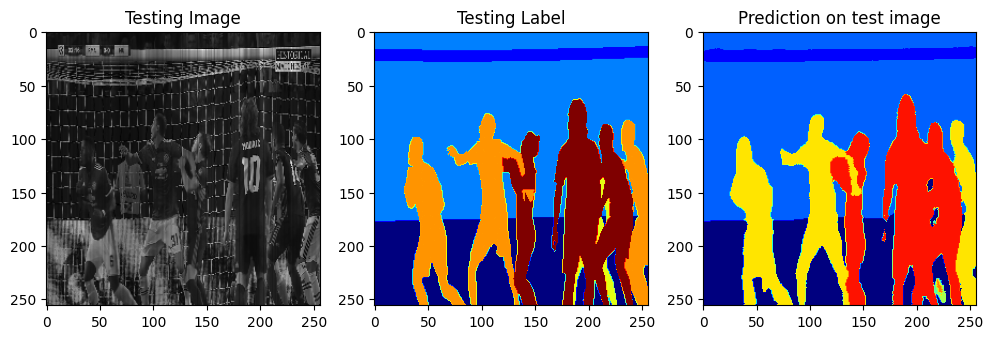

In [36]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()